### Gravity Spy tutorial 2: simulate your own glitch and classify it!

author: Melissa Lopez

email: m.lopez@uu.nl

In [1]:
import gengli
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter
import pycbc
import sys
#FIXME: your path to your Gravity Spy repo
path_to_repo = "/home/melissa.lopez/GravitySpy/"
sys.path.insert(0, path_to_repo)
from gravityspy.classify import classify
from gravityspy.utils import utils
from gravityspy.plot import plot_qtransform

2025-03-15 10:38:53.868515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-15 10:38:54.073994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-15 10:38:54.074028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-15 10:38:54.107960: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 10:38:55.332729: W tensorflow/stream_executor/pla

In this tutorial we will use `gengli` to generate glitch "waveforms" of Blip glitches, inject them in real data and classify them with `Gravity Spy`. Note that `gengli` is `numpy` based, so you can substitute this "waveform" with the `numpy` array of your choice.

Let's define some parameters: we probably want the detector (`ifo`) where we want to make the glitch injection, as well as the desired SNR (`snr`). We usually work at $4 kHZ, but other sampling rates (`srate`), are also welcomed.

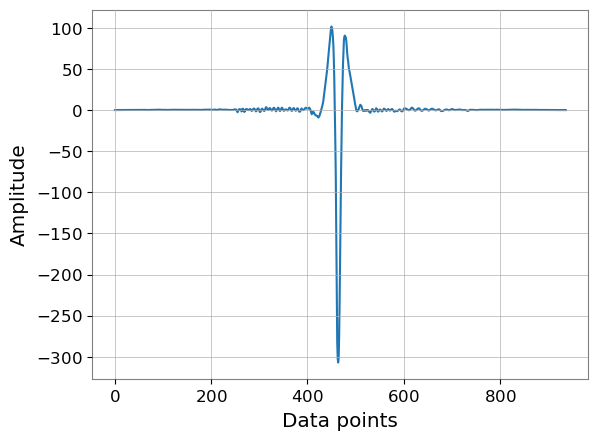

In [2]:
%matplotlib inline 
#Parameters
ifo = 'H1'
channel_name = f'{ifo}:GDS-CALIB_STRAIN' # to use later
snr = 20
srate = 4096
event_time = 0 # now event time is 0 because it is simulated but it could be any float

g = gengli.glitch_generator(ifo)
glitch = g.get_glitch(1, srate=srate, snr=snr)
plt.plot(glitch)
plt.xlabel('Data points'), plt.ylabel('Amplitude')
plt.show()

We have to inject the whitened glitch ($g_w$) in whitened noise ($n_w$).

$s_w$ = $n_w$ + $g_w$

If needed we can always color to a desired PSD.

Let's get the noise to perform the injection. We take 40s noise to have a nice estimate of the PSD. Note that `fetch_open_data` retrieves data at 4kHz. We plot the whitened data, cropping 4s of noise left and right to avoid border effects.

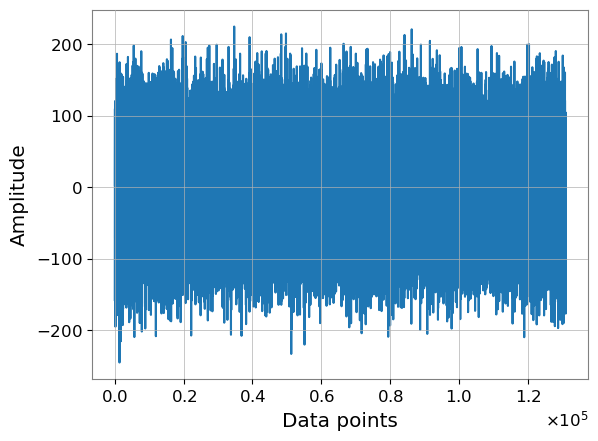

In [3]:
# Define the GPS start and end times for the data segment you want to analyze
# 40s was my option but you can take something else
start, end = 1262540000, 1262540040 
init_time = -20 # the glitch is injected at t0=0, so the initial time of the series is -20

# Fetch open data from the specified interferometer (ifo)
noise = TimeSeries.fetch_open_data(ifo, start, end, sample_rate=srate)

# Convert the data from a gwpy TimeSeries object to a pycbc TimeSeries object
# This is necessary because we want to use pycbc-specific functions on the data
noise = noise.to_pycbc()


# - Whitening: This process flattens the power spectral density (PSD), making all frequencies equally weighted.
# Arguments:
# - len(noise) / (2 * srate): whitening segment length in seconds for estimating the noise PSD
# - len(noise) / (4 * srate): inverse spectrum truncation length (higher truncation reduces noise at high frequencies)
# - remove_corrupted=False: keeps all data points even if the whitening introduces edge effects
# - return_psd=True: also returns the estimated PSD along with the whitened noise
white_noise, psd = noise.whiten(len(noise) / (2 * srate),
                                len(noise) / (4 * srate),
                                remove_corrupted=False,
                                return_psd=True)

# Plotting white noise
plt.plot(white_noise[srate * 4 : -srate * 4])
plt.xlabel('Data points')
plt.ylabel('Amplitude')
plt.show()

We add the glitch into the center of the data, since we will create a spectrogram later on and this is recommended. Plotting the region where the glitch is injected looks pretty good!

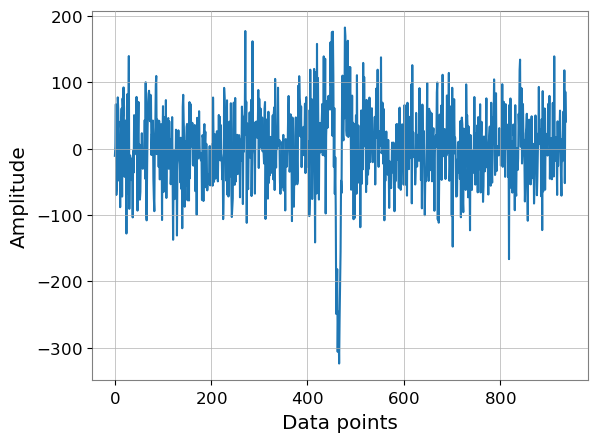

In [4]:
# Get the length (number of data points) of the noise array
length = noise.shape[-1]

# Get the length of the glitch signal (number of data points)
len_glitch = glitch.shape[-1]

# Define the injection time for the glitch (in seconds)
# This injects the glitch halfway through the noise data
t_inj = 0.5 * length / srate 

# Calculate the starting index where the glitch will be injected into white_noise
# Explanation:
# - (t_inj * srate / length): ratio to scale with respect to the noise length
# - len(white_noise): total number of points in white_noise
# - Subtract half the glitch length to center the glitch at t_inj
id_start = int((t_inj * srate / length) * len(white_noise)) - len_glitch // 2

# Add the glitch signal into the white_noise at the computed position
# This directly modifies white_noise by adding glitch amplitudes to the selected segment
white_noise[id_start:id_start + len_glitch] += glitch

# Plotting the injected noise
plt.plot(white_noise[id_start:id_start + len_glitch])
plt.xlabel('Data points')
plt.ylabel('Amplitude')
plt.show()

In [5]:
# We transform the numpy array to gwpy Timeseries
glitch_series = TimeSeries(white_noise, t0=init_time, sample_rate=srate,
                           name=ifo)


Let's visualize what the inpurt of `GravitySpy` looks like. From the previous tutorial we have:

In [6]:
%%capture
config = utils.GravitySpyConfigFile()
plot_time_ranges = config.plot_time_ranges
plot_normalized_energy_range = config.plot_normalized_energy_range

specsgrams, q_value = utils.make_q_scans(event_time=event_time,
                                         timeseries=glitch_series,
                                         config=config,
                                         channel_name=channel_name)

ind_fig_all, super_fig = plot_qtransform(specsgrams,
                                         plot_normalized_energy_range,
                                         plot_time_ranges,
                                         ifo,
                                         event_time)

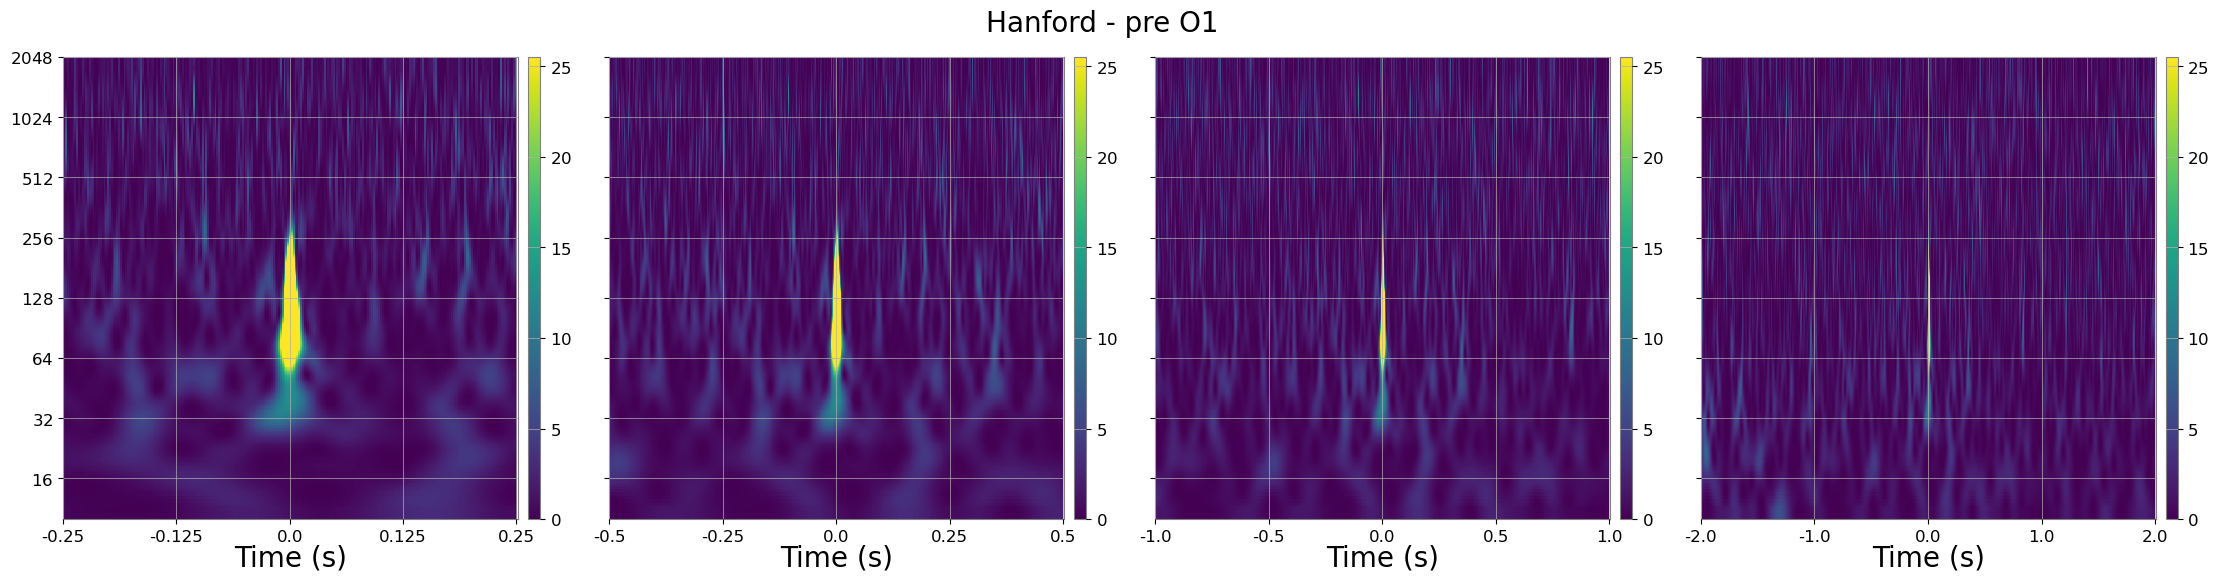

In [7]:
%matplotlib inline
super_fig

This is a nice looking Blip. Now we classify it to see what `Gravity Spy` thinks.

In [ ]:
# I use Siddharth Soni's model but the repo has more models to try!
path_to_model = f'{path_to_repo}/models/sidd-cqg-paper-O3-model.h5'

results_glitch = classify(event_time=0,
                          channel_name=channel_name,
                          path_to_cnn=path_to_model,
                          timeseries=glitch_series)
results_glitch['ml_label'].value[0], results_glitch['ml_confidence'].value[0]

/home/melissa.lopez/.conda/envs/gengli_env/lib/python3.9/site-packages/gwpy/types/series.py:981: UserWarning: TimeSeries.crop given start smaller than current start, crop will begin when the Series actually starts.
  warn(
/home/melissa.lopez/.conda/envs/gengli_env/lib/python3.9/site-packages/gwpy/types/series.py:991: UserWarning: TimeSeries.crop given end larger than current end, crop will begin when the Series actually ends.
  warn(


This is indeed a Blip with >0.99 confidence

This is the end of the second tutorial. I hope that you enjoyed it!